## **DISCLAIMER:**


* It is necessary to create a shortcut to the weights of the best models we have got in the main folder of your Google Drive: https://drive.google.com/drive/folders/1XVMf5tbu1xUfAs3tkwfAmBPwRT3D1Lo1?usp=sharing
  

* The Dataset downloaded from Kaggle should be uploaded to Google Drive in the main folder with the name "*Development_Dataset*"

In the first part of this notebook it is presented the pipeline that we used for the Pead dataset which had the particularity that all the photos were taken from a perspective that included also some external grass into the picture.

## **Installing all the dependancies**

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-gwrp4efq
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-gwrp4efq
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=d1615186e4965d8826e17aedb42760578ee877f23eb30ee1be5f3dc3c8e4f40e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ufwi756/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
%%capture

import os
import multiprocessing as mp
import gc

from functools import partial

import numpy as np
np.random.seed(1234)

import pandas as pd

import cv2

import imgaug as ia
ia.seed(1234)
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.keras.backend.set_image_data_format("channels_last")

import segmentation_models as sm


SEED = 1234
tf.random.set_seed(SEED)  

## **Data Loading & Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = os.path.join('/content/drive/My Drive', 'Development_Dataset/Training')
train_dir = dataset_dir + "/" + "Pead" + "/" + "Mais"

classes = [
    'background',
    'crop',
    'weed'
]

n_classes = len(classes)

filenames = os.listdir(train_dir + "/Images/")
masks = os.listdir(train_dir + "/Masks/")

print("Training data:", len(filenames))

Training data: 105


In [ ]:
filenames_train, filenames_val = train_test_split(filenames,
                                                  test_size=.2,
                                                  shuffle=True,
                                                  random_state=1234)

masks_train, masks_val = train_test_split(masks,
                                                  test_size=.2,
                                                  shuffle=True,
                                                  random_state=1234)

print("Training data (after split):", len(filenames_train))
print("Validation data:", len(filenames_val))

Training data (after split): 84
Validation data: 21


In [ ]:
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, 512, 512)
else:
    input_shape = (512, 512, 3)

def preprocess(img, image_size, mask): 
    img = cv2.resize(img, image_size)
        
    if mask == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img
    
def preprocess_input(images, input_shape, mask=False):
    
    if tf.keras.backend.image_data_format() == 'channels_first':
        image_size = (input_shape[1], input_shape[2])
    else:    
        image_size = (input_shape[0], input_shape[1])

    func_preprocess = partial(preprocess,
                              image_size=image_size,
                              mask=mask)
    
    map_iterator = map(func_preprocess, images)
    resized = list(map_iterator)

    return resized

[47 83 38 53 76 24 15 49 23 26]


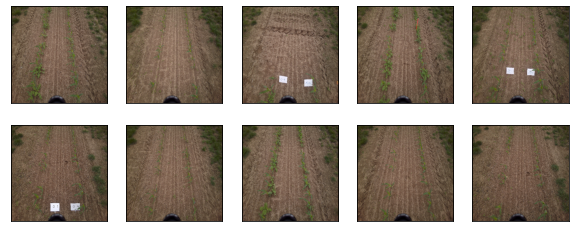

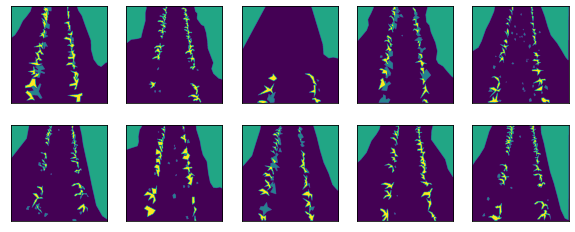

In [ ]:
indexes = np.random.RandomState(1234).choice(range(0, len(filenames)), 10)
print(indexes)

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = indexes[i]
    img = cv2.imread(train_dir + "/Images/" + filenames[idx])
    img = preprocess_input([img], input_shape)
    img = np.array(img)[0]
    plt.imshow(img)

plt.show()

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = indexes[i]
    img = cv2.imread(train_dir + "/Masks/" + filenames[idx][:-3] + "png")
    img = preprocess_input([img], input_shape, mask=True)
    img = np.array(img)[0]
    plt.imshow(img)

plt.show()

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self,which_subset, dataset_dir, subset_filenames, img_generator=None, mask_generator=None, out_shape=[512, 512]):

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.out_shape = out_shape
    self.n = self.__len__()

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename))
    mask = Image.open(os.path.join(self.dataset_dir, "Masks" , curr_filename[:-3] + "png"))

    #Here we declare the points to use for the PerspectiveTransform

    pt_A = [480,2464]
    pt_B = [2980,2464]
    pt_C = [2190,0]
    pt_D = [1160,0]
    
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                        [0, 512],
                        [512, 512],
                        [512, 0]])
    
    M = cv2.getPerspectiveTransform(input_pts,output_pts)

    img = cv2.warpPerspective(np.float32(img),M,(512, 512),flags=cv2.INTER_LINEAR)
    mask = cv2.warpPerspective(np.float32(mask),M,(512, 512),flags=cv2.INTER_LINEAR)

    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    mask_arr =new_mask_arr  

    masks = [(mask_arr == v) for v in range(1,3)]
    mask = np.stack(masks, axis=-1).astype('float')
        
    # Add background 
    if mask.shape[-1] != 1:
      background = 1 - mask.sum(axis=-1, keepdims=True)
      mask_arr = np.concatenate((mask, background), axis=-1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr       

    return np.float32(img_arr), np.float32(out_mask)

In [ ]:
img_h = 512
img_w = 512

dataset = CustomDataset( 'training',train_dir, filenames_train, 
                        img_generator=img_data_gen, mask_generator=mask_data_gen)
dataset_valid = CustomDataset( 'validation',train_dir, filenames_val)


With this package the masks should be treated as a 512x512x3 One-Hot Matrix

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 3]))


train_dataset = train_dataset.batch(5)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 3]))
valid_dataset = valid_dataset.batch(5)

valid_dataset = valid_dataset.repeat()

In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


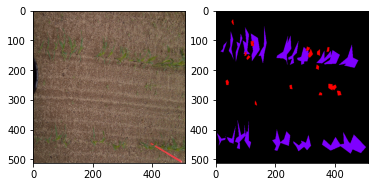

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ...])   # First element (squeezing channel dimension)

target = tf.argmax(target, -1)

target_img = np.zeros([target.shape[0], target.shape[1]])
 
target_img[np.where(target == 2)] = 0
target_img[np.where(target == 0)] = 1
target_img[np.where(target == 1)] = 2

target=target_img

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1,3 ):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [ ]:
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    #y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

##**Model**

In [ ]:
n_classes = 3
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([ 1, 5,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5,per_image=True)]


model = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

71892992/71892840 [==============================] - 2s 0us/step


##**Training**

In [ ]:
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                   save_best_only=False ,
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=80,  #### set repeat in training dataset
          validation_data=valid_dataset,
          validation_steps=len(filenames_val),
          steps_per_epoch=16,
          callbacks=callbacks)


Epoch 1/80
16/16 [==============================] - 207s 11s/step - loss: 0.5386 - iou_score: 0.3355 - val_loss: 0.9399 - val_iou_score: 0.4412
Epoch 2/80
16/16 [==============================] - 96s 6s/step - loss: -0.1793 - iou_score: 0.5537 - val_loss: 0.6589 - val_iou_score: 0.3868
Epoch 3/80
16/16 [==============================] - 90s 6s/step - loss: -0.3301 - iou_score: 0.5807 - val_loss: 0.3944 - val_iou_score: 0.3937
Epoch 4/80
16/16 [==============================] - 89s 6s/step - loss: -0.4311 - iou_score: 0.6081 - val_loss: 0.1890 - val_iou_score: 0.4291
Epoch 5/80
16/16 [==============================] - 89s 6s/step - loss: -0.4794 - iou_score: 0.6172 - val_loss: 0.0978 - val_iou_score: 0.4580
Epoch 6/80
16/16 [==============================] - 89s 6s/step - loss: -0.4795 - iou_score: 0.6140 - val_loss: 0.2026 - val_iou_score: 0.4455
Epoch 7/80
16/16 [==============================] - 89s 6s/step - loss: -0.5342 - iou_score: 0.6406 - val_loss: 0.3356 - val_iou_score: 0.461

(512, 512)
(512, 512)
[0. 1. 2.]
tf.Tensor(0.53740907, shape=(), dtype=float32)
504514
174397
(2464, 3280)


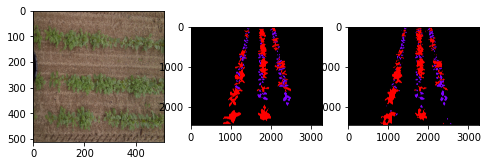

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

out_sigmoid = tf.keras.backend.greater(out_sigmoid,0.5)
out_sigmoid = tf.keras.backend.cast(out_sigmoid, tf.keras.backend.floatx())
#print(dice_loss(target[0],out_sigmoid))
#print("----------")

target = np.array(target[0, ...])

target = tf.argmax(target, -1)

predicted_class = tf.argmax(out_sigmoid, -1)

predicted_class = predicted_class[0, ...]



print(target.shape)
print(predicted_class.shape)


target_img = np.zeros([target.shape[0], target.shape[1]])
 
target_img[np.where(target == 2)] = 0
target_img[np.where(target == 0)] = 1
target_img[np.where(target == 1)] = 2

target=target_img

print(np.unique(target))

predicted_img = np.zeros([target.shape[0], target.shape[1]])
 
predicted_img[np.where(predicted_class == 2)] = 0
predicted_img[np.where(predicted_class == 0)] = 1
predicted_img[np.where(predicted_class == 1)] = 2

predicted_class = predicted_img



pt_A = [480,2463]
pt_B = [2980,2463]
pt_C = [2190,0]
pt_D = [1160,0]

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, 511],
                        [511, 511],
                        [511, 0]])

Minv = cv2.getPerspectiveTransform(output_pts,input_pts)
predicted_class = cv2.warpPerspective(np.float32(predicted_class),Minv,(3280,2464),flags=cv2.INTER_LINEAR)
target = cv2.warpPerspective(np.float32(target),Minv,(3280,2464),flags=cv2.INTER_LINEAR)

print(meanIoU(target,predicted_class))

print(np.count_nonzero(predicted_class == 2))
print(np.count_nonzero(predicted_class == 1))



print(predicted_class.shape)
# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([predicted_class.shape[0], predicted_class.shape[1], 3])


target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255


ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

## **2nd Part: Implementation of all the other models**

##Bipbip

In [ ]:
IMAGE_ORDERING='channels_last'

def get_segmentation_model1(input, output):

    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    return model

In [ ]:
import keras
from keras.models import *
from keras.layers import *


if IMAGE_ORDERING == 'channels_first':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
elif IMAGE_ORDERING == 'channels_last':
    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

def get_vgg_encoder(input_height=256,  input_width=256, pretrained='imagenet'):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)
    f5 = x

    if pretrained == 'imagenet':
        VGG_Weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(VGG_Weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [ ]:
from keras.models import *
from keras.layers import *

if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1


def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f4

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(512, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f3], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(256, (3, 3), padding='valid', activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f2], axis=MERGE_AXIS))
    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(128, (3, 3), padding='valid' , activation='relu' , data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=MERGE_AXIS))

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(64, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)
    
    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)

    o = (ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING))(o)
    o = (Conv2D(32, (3, 3), padding='valid', activation='relu', data_format=IMAGE_ORDERING))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same',
               data_format=IMAGE_ORDERING)(o)
    

    model = get_segmentation_model1(img_input, o)

    return model



def vgg_unet1(n_classes, input_height=416, input_width=608, encoder_level=3):

    model = _unet(n_classes, get_vgg_encoder,
                  input_height=input_height, input_width=input_width)
    model.model_name = "vgg_unet"
    return model

In [ ]:
# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy', meanIoU]

model_bip = vgg_unet1(n_classes=3 ,  input_height=512, input_width=512  )
model_bip.compile(optimizer=optimizer, loss=loss, metrics=metrics)

58892288/58889256 [==============================] - 1s 0us/step


LEGEND:


*   wm = Weedelec with crop Mais
*   wh = Weedelec with crop Haricot
*   rm = Roseau with crop Mais
*   rh = Roseau with crop Haricot
*   pm = Pead with crop Mais
*   ph = Pead with crop Haricot
*   bip = Bipbip (merged crops)



In [ ]:
model_wm = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_wm.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

model_wh = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_wh.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

model_rh = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_rh.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

model_rm = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_rm.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

model_ph = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_ph.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

model_pm = sm.FPN(BACKBONE, encoder_weights='imagenet',classes=3)
model_pm.compile(
    'Adam',
    loss=total_loss,
    metrics=metrics,
)

In [ ]:
model_rm.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec17_19-00-15/ckpts/cp_33.ckpt')

model_rh.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec18_08-24-09/ckpts/cp_18.ckpt')

model_wm.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec18_18-46-53/ckpts/cp_21.ckpt')

model_wh.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec18_21-52-43/ckpts/cp_22.ckpt')

model_bip.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec22_18-50-10/ckpts/cp_75.ckpt')

model_ph.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec26_18-50-43/ckpts/cp_18.ckpt')

model_pm.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec26_20-20-28/ckpts/cp_25.ckpt')

##**Test Data Predictions**

In [ ]:
Test_dir = os.path.join('/content/drive/My Drive', 'Development_Dataset/Test_Dev')
Test_filenames={}
for robot in {"Bipbip", "Pead" , "Roseau", "Weedelec"}:
  for crop in {"Haricot","Mais"}:
    Test_filename = os.listdir(Test_dir + "/" + robot + "/" + crop + "/Images/")
    Test_filenames[robot+crop]=Test_filename

In the encoding, we needed to make distinctions between the datasets used: in the case of Pead, we had to preprocess the test images like we did for the training ones to solve the perspective issue. Then we used for each dataset its own model, loaded with its own weights.

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

submission_dict = {}

for robot in {"Bipbip","Pead" , "Roseau", "Weedelec"}:
  for crop in {"Haricot","Mais"}:
    for image in Test_filenames[robot+crop]:

      submission_dict[image[:-4]] = {}

      img = Image.open(Test_dir + "/" + robot + "/" + crop + "/Images/" + image).convert('RGB')
      dim = img.size
      
      pt_A = [480,2464]
      pt_B = [2980,2464]
      pt_C = [2190,0]
      pt_D = [1160,0]

      output_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
      input_pts = np.float32([[0, 0],
                              [0, 512],
                              [512, 512],
                              [512, 0]])

      if robot == "Pead":
        M = cv2.getPerspectiveTransform(output_pts,input_pts)
        img = cv2.warpPerspective(np.float32(img),M,(512,512),flags=cv2.INTER_NEAREST)
        img_array = np.array(img)
      else:
        img=img.resize((img_h,img_w))
        img_array = np.array(img)

      img_array = np.expand_dims(img_array, 0)
      img_array= tf.convert_to_tensor(img_array, dtype=tf.float32)

      if robot == 'Roseau' and crop == 'Mais':
        mask_prediction = model_rm.predict(img_array)
      
      elif robot == 'Roseau' and crop == 'Haricot':
        mask_prediction = model_rh.predict(img_array)

      elif robot == 'Weedelec' and crop == 'Mais':
        mask_prediction = model_wm.predict(img_array)

      elif robot == 'Weedelec' and crop == 'Haricot':
        mask_prediction = model_wh.predict(img_array)

      elif robot == 'Bipbip':
        mask_prediction = model_bip.predict(img_array)

      elif robot == 'Pead' and crop == 'Haricot':
        mask_prediction = model_ph.predict(img_array)

      elif robot == 'Pead' and crop == 'Mais':
        mask_prediction = model_pm.predict(img_array)

      mask_prediction = tf.keras.backend.greater(mask_prediction,0.5)
      mask_prediction = tf.keras.backend.cast(mask_prediction, tf.keras.backend.floatx())


      predicted_class = tf.argmax(mask_prediction, -1)

      predicted_class = predicted_class[0, ...]

      predicted_img = np.zeros([img_h, img_w])

      if robot == 'Bipbip':
        predicted_img[np.where(predicted_class == 2)] = 2
        predicted_img[np.where(predicted_class == 0)] = 0
        predicted_img[np.where(predicted_class == 1)] = 1
        

      #Here we need to revert the order of the classes to 0 - Background, 1 - Crop, 2 - Weed 
      #because in the ClassGenerator we created them as  2 - Background, 0 - Crop, 1 - Weed since the sm_models
      #package required the background class to be the last
      
      else:
        predicted_img[np.where(predicted_class == 2)] = 0
        predicted_img[np.where(predicted_class == 0)] = 1
        predicted_img[np.where(predicted_class == 1)] = 2
      predicted_class = predicted_img
      
      if robot == "Pead" :
        Minv = cv2.getPerspectiveTransform(input_pts,output_pts)
        predicted_class = cv2.warpPerspective(np.float32(predicted_class),Minv,(3280,2464),flags=cv2.INTER_NEAREST)

      submission_dict[image[:-4]]['shape'] = [dim[1],dim[0]]
      submission_dict[image[:-4]]['team'] = robot
      submission_dict[image[:-4]]['crop'] = crop
      submission_dict[image[:-4]]['segmentation'] = {}
      
      prediction_img = np.array(predicted_class)
      if robot == "Bipbip" :predicted_class = cv2.resize(prediction_img , (2048,1536), interpolation=cv2.INTER_NEAREST)
      if robot == "Pead" :predicted_class = cv2.resize(np.int32(prediction_img), (3280,2464), interpolation=cv2.INTER_NEAREST)
      if robot == "Roseau" :predicted_class = cv2.resize(prediction_img,(dim[0],dim[1]), interpolation=cv2.INTER_NEAREST)
      if robot == "Weedelec" :predicted_class = cv2.resize(prediction_img, (5184,3456), interpolation=cv2.INTER_NEAREST)


      rle_encoded_crop = rle_encode(predicted_class == 1)
      
      rle_encoded_weed = rle_encode(predicted_class == 2)   

      submission_dict[image[:-4]]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[image[:-4]]['segmentation']['weed'] = rle_encoded_weed


In [ ]:
import json

filename = 'submission.json'

with open(filename, 'w') as fp:
    json.dump(submission_dict, fp)